# Attribute Importance for Concept Drift - Analysis on the BPI challenge 2017 dataset

The presented attribute importance evaluation framework is applied to the 2017 BPI challgen dataset. This dataset is of the loan application process of a Dutch finance institution.

## Setup
### Imports

In [35]:
# imports
import helper
import pm4py
import pandas as pd
import numpy as np
from pm4py.objects.log.importer.xes import importer as xes_importer

from processdrift.framework import drift_detection
from processdrift.framework import drift_explanation
from processdrift.framework import feature_extraction
from processdrift.framework import population_comparison
from processdrift.framework import windowing
from processdrift.framework import change_point_extraction


### Data settings and event log loading

In [36]:
# data settings
data_file_path = 'data/real/bpi_challenge_2013_incidents.xes'

## Present basic analysis

In [37]:
# load event log
event_log = xes_importer.apply(data_file_path)

parsing log, completed traces :: 100%|██████████| 7554/7554 [00:11<00:00, 659.27it/s] 


In [38]:
# get some basic statistics (number of events, number of traces, attributes...)
basic_stats = {}

# event statistics
event_stream = pm4py.convert.convert_to_event_stream(event_log)
number_events = len(event_stream)
basic_stats['Number of events'] = number_events

event_attributes = pm4py.statistics.attributes.log.get.get_all_event_attributes_from_log(event_log)
basic_stats['Event attributes'] = str(event_attributes)

number_event_attributes = len(event_attributes)
basic_stats['Number event attributes'] = number_event_attributes

# trace statistics
number_traces = len(event_log)
basic_stats['Number traces'] = number_traces

trace_attributes = pm4py.statistics.attributes.log.get.get_all_trace_attributes_from_log(event_log)
basic_stats['Trace attributes'] = str(trace_attributes)

number_trace_attributes = len(trace_attributes)
basic_stats['Number trace attributes'] = number_trace_attributes

basic_stats_series = pd.Series(basic_stats)
basic_stats_series

Number of events                                                       65533
Event attributes           {'org:resource', 'org:role', 'concept:name', '...
Number event attributes                                                   10
Number traces                                                           7554
Trace attributes                                                       set()
Number trace attributes                                                    0
dtype: object

In [39]:
helper.get_examples_of_trace_attributes(event_log, 10)

,concept:name
0,1-737346491
1,1-740300732
2,1-738157101
3,1-740359566
4,1-740585463
5,1-739548890
6,1-718977997
7,1-730901481
8,1-734879581
9,1-739200627


In [40]:
helper.get_examples_of_event_attributes(event_log, 10, event_attributes)

,org:group,resource country,organization country,org:resource,organization involved,org:role,concept:name,impact,product,time:timestamp
0,S42,Sweden,se,Tobias,Org line C,V3_2,Completed,Medium,PROD453,2012-05-03 11:44:40+02:00
1,G51 2nd,Brazil,cn,Aline,Org line G4,NaN,Accepted,Medium,PROD753,2012-05-02 10:21:00+02:00
2,N36,USA,us,Sadia,Org line C,V3_2,Accepted,Low,PROD245,2012-04-17 17:02:30+02:00
3,S42,Sweden,se,Joakim,Org line C,V3_2,Completed,Medium,PROD544,2012-05-02 10:48:02+02:00
4,G96,INDIA,pl,Noel,Org line C,V3_2,Completed,Low,PROD494,2012-05-01 15:52:15+02:00
5,G96,POLAND,pl,Tadeusz,Org line C,V3_2,Completed,Low,PROD363,2012-05-03 16:46:29+02:00
6,G97,POLAND,pl,Jacek,Org line C,V3_2,Accepted,Low,PROD698,2012-04-30 09:56:34+02:00
7,N14 2nd,POLAND,be,Paulina,Org line A2,A2_1,Accepted,Medium,PROD776,2012-05-04 16:24:05+02:00
8,S42,0,se,Siebel,Org line C,V3_2,Completed,Medium,PROD453,2012-05-11 01:19:23+02:00
9,N38,USA,us,Ryan,Org line C,V3_2,Accepted,Medium,PROD253,2012-05-03 18:01:29+02:00


In [41]:
attribute_level_type_list = helper.automatically_get_attributes_and_data_types(event_log)

### Configure Primary Drift Detector

In [42]:
# # alternative 1: ProDrift Drift detector
# primary_process_drift_detector = drift_detection.ProDriftDD(path_to_prodrift='ProDrift2.5/ProDrift2.5.jar',
#                                                                         drift_detection_mechanism='runs',
#                                                                         window_size=200,
#                                                                         window_mode='adaptive',
#                                                                         detect_gradual_as_well=False)

In [43]:
# alternative 2: Configure custom drift detector
# the user can select 
# - a primary feature extractor, specifying which primary axis feature to use
# - a window generator (fixed size or adaptive) incl. the window sizes and further settings
# - a population comparer
# - a threshold for detecting the change points

primary_feature_extractor = feature_extraction.RunsFE()
primary_window_generator = windowing.FixedWG(window_size=300, slide_by=10)
primary_population_comparer = population_comparison.GTestPC(0)
primary_phi = 10
primary_rho = 3

primary_change_point_extractor = change_point_extraction.PhiFilterCPE(primary_phi, primary_rho)

primary_threshold = 0.05
primary_process_drift_detector = drift_detection.HypothesisTestDD(primary_feature_extractor, 
                                                               primary_window_generator,
                                                               primary_population_comparer, 
                                                               primary_change_point_extractor)

In [44]:
# alternative 3: drift detector true known for debugging purposes
# TODO must be deactivated before real analysis is conducted
# primary_process_drift_detector = drift_detection.DriftDetectorTrueKnown([655, 2087, 2390, 2674, 2850, 4849, 6522, 11353])

### Configure Secondary Drift Detectors

The user can specify a list of secondary drift detectors.

In [45]:
secondary_window_size = 200
secondary_slide_by = 20

max_distance = 300

secondary_window_generator = windowing.FixedWG(secondary_window_size, slide_by=secondary_slide_by)

secondary_phi = secondary_window_size / secondary_slide_by * 0.5
secondary_rho = 1
secondary_threshold = 0.05

change_point_extractor = change_point_extraction.PhiFilterCPE(secondary_threshold, secondary_phi, secondary_rho)

secondary_drift_detectors = drift_detection.get_attribute_drift_detectors(attribute_level_type_list,
                                                                         secondary_window_generator, 
                                                                         change_point_extractor,
                                                                         min_samples_per_test=0)

# change the population comparer to hellingers distance
for sdd in secondary_drift_detectors:
    sdd.population_comparer = population_comparison.HellingerDistancePC()

## Run the Change Point Explainer

In [46]:
# create the change point explainer
drift_explainer = drift_explanation.DriftExplainer(primary_process_drift_detector, secondary_drift_detectors)

# get the change point explanations
primary_and_secondary_changes = drift_explainer.get_possible_drift_explanations(event_log, max_distance=max_distance)
primary_and_secondary_changes

<AxesSubplot:>

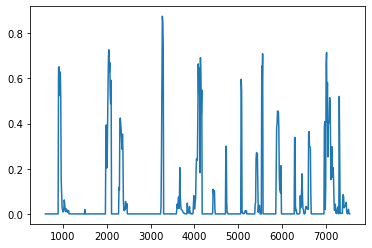

In [47]:
primary_and_secondary_changes.primary_dd_result.change_series.plot()

In [48]:
primary_and_secondary_changes.secondary_dd_result_dictionary['impact'].change_series

399    0.843666
419    0.867643
439    0.862824
459    0.893973
479    0.875287
499    0.889238
519    0.911184
539    0.916639
559    0.925292
579    0.909504
599    0.864110
619    0.857748
639    0.901559
659    0.890191
679    0.913522
699    0.937493
719    0.916536
739    0.902459
759    0.926460
779    0.931438
799    0.922645
819    0.855708
839    0.850453
859    0.841192
879    0.844872
899    0.886120
dtype: float64

In [34]:
impact_dd = None
for sdd in secondary_drift_detectors:
    if sdd.name == 'impact':
        impact_dd = sdd

impact_dd.get_changes(event_log, around_change_points=primary_and_secondary_changes.primary_dd_result.change_points, max_distance=max_distance)

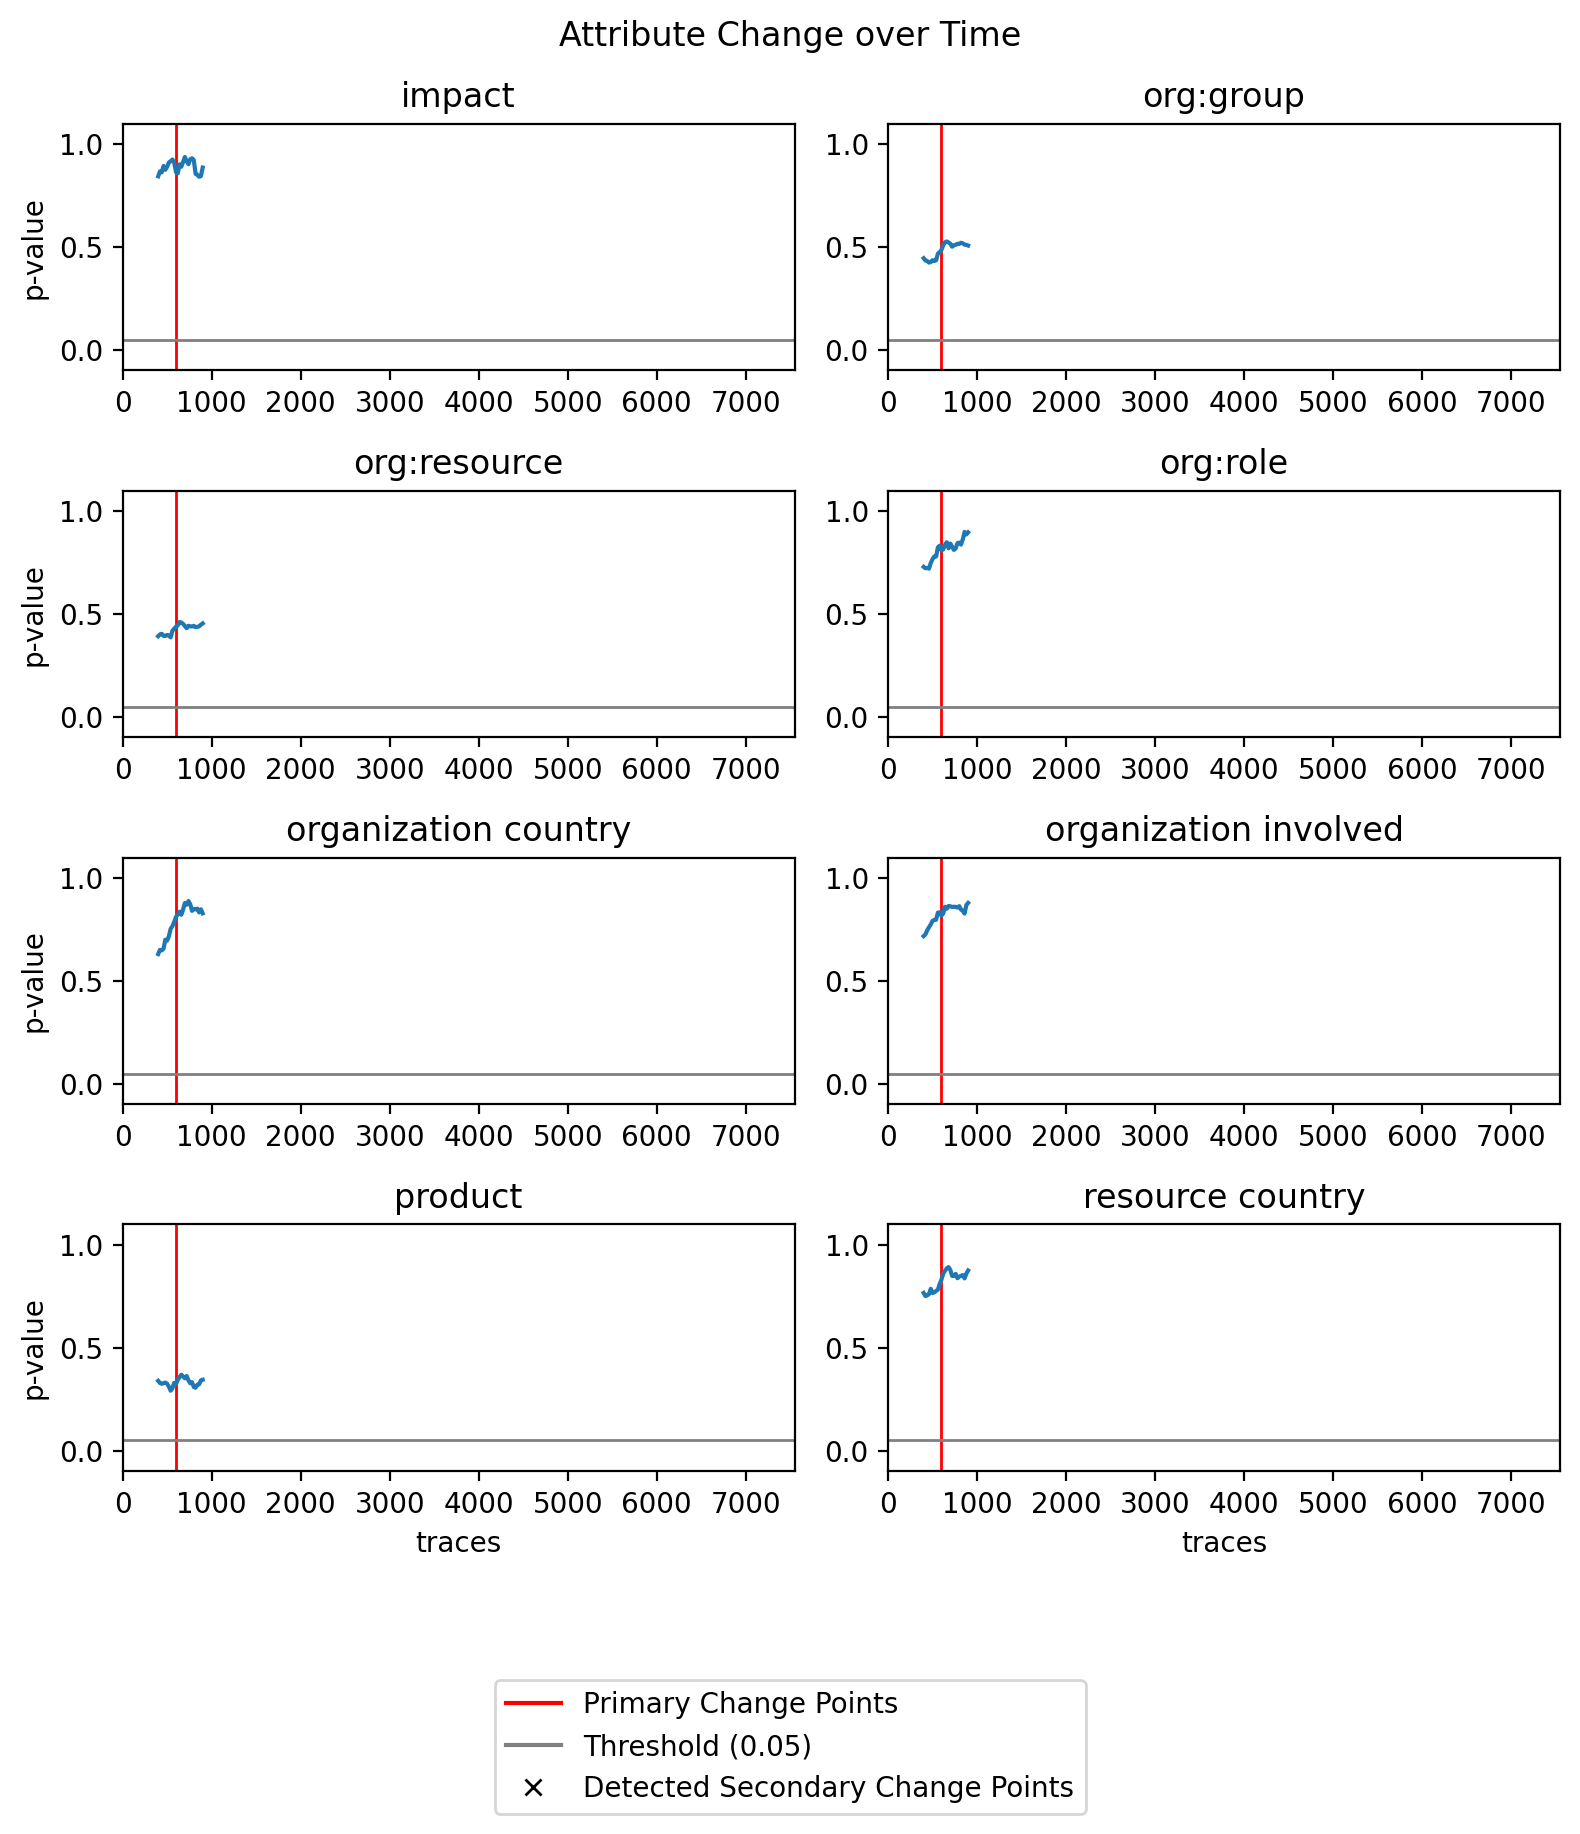

<module 'matplotlib.pyplot' from 'c:\\Users\\Lennart\\Tools\\Anaconda3\\envs\\concept_drift\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [49]:
primary_and_secondary_changes.plot()

In [50]:
# put change explanations into a pandas data frame for better analysis
# for that we have to flatten the dictionary
flattended_change_explanations = []
for scp, scp_explanations in change_explanations.items():
    for scp_explanation in scp_explanations:
        dictionary = scp_explanation.copy()
        dictionary['secondary change point'] = scp
        flattended_change_explanations.append(dictionary)

df = pd.DataFrame(flattended_change_explanations)
df.set_index('secondary change point')

NameError: name 'change_explanations' is not defined

14 change explanations where found. 

5 of these are by the feature "org:resource" which is an event-level field. Therefore, we investigate this field further.

In [ ]:
# shown an example for data in "org:resource"
import numpy as np
rng = np.random.default_rng(seed=123)
sample_trace_ids = rng.choice(range(len(event_log)), 10)

for sample_trace_id in sample_trace_ids:
    sample_trace = event_log[sample_trace_id]

    # sample a random event
    sample_event_id = rng.choice(range(len(sample_trace)))
    sample_event = sample_trace[sample_event_id]
    print(sample_event["org:resource"])

User_21
User_121
User_46
User_29
User_1
User_37
User_117
User_5
User_1
User_1


The field appears to hold user information.

Maybe the field always changes significantly?

In [ ]:
from processdrift.framework import drift_detection, feature_extraction

feature_extractor = feature_extraction.AttributeFeatureExtractor('event', 'org:resource')
drift_detector = drift_detection.DriftDetector(feature_extractor, window_generator=secondary_window_generator, population_comparer=secondary_population_comparer)

changes = drift_detector.get_changes(event_log)

<AxesSubplot:>

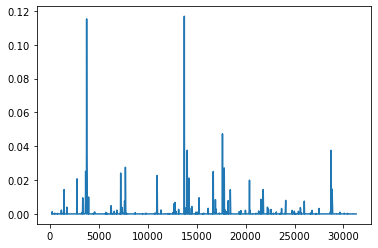

In [ ]:
changes['change_series'].plot()